In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from scipy.stats import uniform

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read in data from csv
filename = 'creditcard.csv'
file = open(filename, 'rt')
reader = csv.reader(file, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader)
data = np.array(x)

In [3]:
#remove headers and split features from labels
header, raw_data = np.vsplit(data, [1])
raw_x, raw_y = np.hsplit(raw_data, [30])
x_train, x_val, y_train, y_val = train_test_split(raw_x, raw_y, test_size=0.25)
print(x_train.shape)
print(x_val.shape)

(213605, 30)
(71202, 30)


In [29]:

#create classifier and param ranges
randHGBC = HistGradientBoostingClassifier()
weights = np.linspace(0.0, 0.99, 20)
max_iter = np.linspace(100, 164, 14, dtype=int)

#specify scorer
rScorer = make_scorer(f1_score, pos_label='"1"')
distributions = {'class_weight': [{0:x, 1:1.0-x} for x in weights], 'learning_rate': [0.01, 0.1, 0.5, 1], 'max_iter': max_iter, 
        'max_leaf_nodes': [None, 31]}

#run randomized search on given distribution of parameters
randModel = RandomizedSearchCV(randHGBC, distributions, random_state=0, scoring=rScorer)
search = randModel.fit(x_train, np.ravel(y_train))
search.best_params_
search.best_score_

{'max_leaf_nodes': 31,
 'max_iter': 159,
 'learning_rate': 0.1,
 'class_weight': {0: 0.10421052631578948, 1: 0.8957894736842105}}

In [40]:
#set model to classifier with best parameters accordind to random search
model = search.best_estimator_.fit(x_train, np.ravel(y_train))
y_predict= model.predict(x_val)
confusion_matrix(np.ravel(y_val), np.ravel(y_predict))


array([[71054,    21],
       [   18,   109]], dtype=int64)

0.8497854077253219
Confusion matrix, without normalization
[[71068     7]
 [   28    99]]
Normalized confusion matrix
[[9.99901512e-01 9.84875132e-05]
 [2.20472441e-01 7.79527559e-01]]


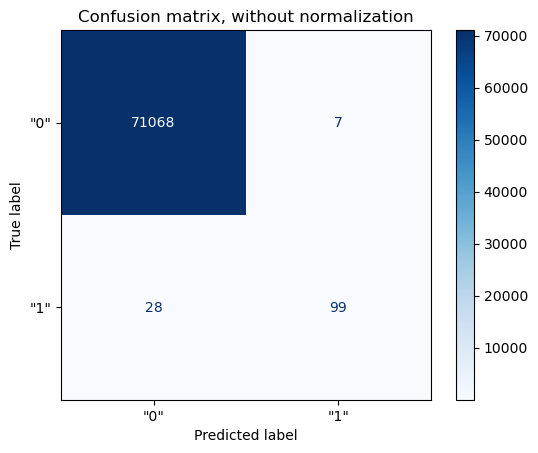

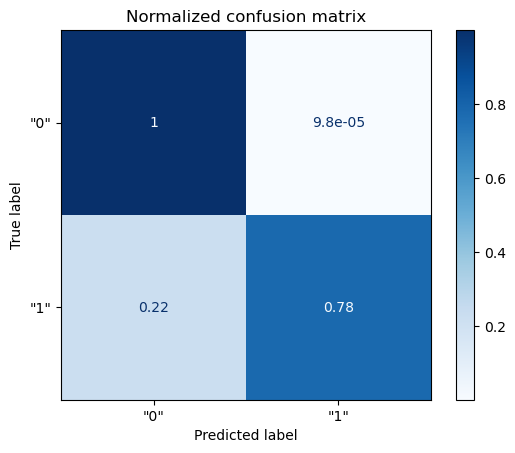

In [38]:
print(f1_score(y_val, y_predict, pos_label='"1"'))
#displays confusion matrix with and without normalization
titles = [
    ("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true"),
]
for title, normalize in titles:
    disp = ConfusionMatrixDisplay.from_estimator(
        model, x_val, np.ravel(y_val), cmap=plt.cm.Blues, normalize = normalize
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

In [32]:
#create classifier
HGBC = HistGradientBoostingClassifier()
weights = np.linspace(0.0, 0.5, 10)    #weight range
max_iter = np.linspace(100, 256, 8, dtype=int)
#parameters for grid search
param = {'class_weight': [{0:x, 1:1.0-x} for x in weights], 'learning_rate': [0.01, 0.1, 0.5], 'max_iter': max_iter, 
        'max_leaf_nodes': [None, 31]}
#specify scorer to use in grid search
rScorer = make_scorer(f1_score, pos_label='"1"')
#run grid search
grid = GridSearchCV(HGBC, param_grid=param, scoring=rScorer)
gridModel = grid.fit(x_train, np.ravel(y_train))
#display best parameters found with f1 score
print(grid.best_params_)
print(grid.best_score_)

KeyboardInterrupt: 

In [11]:
#fit model with balanced class weight and otherwise default hyperparameters
gridModel = grid.best_estimator_.fit(x_train, np.ravel(y_train))
gridModel.score(x_val, np.ravel(y_val))

0.99693828825033

In [ ]:
#cross validate model score and display parameters
cv_scores = cross_val_score(gridModel, raw_x, np.ravel(raw_y), cv = 5)
print (cv_scores.mean(), cv_scores.std())
gridModel.get_params(deep=True)

In [16]:
#initialize variables for some metrics
y_predict= gridModel.predict(x_val)

tn, fp, fn, tp = confusion_matrix(np.ravel(y_val), np.ravel(y_predict)).ravel()
print(tn, fp, fn, tp)
confusion_matrix(np.ravel(y_val), np.ravel(y_predict))
#fpr, tpr, thresholds = roc_curve(np.ravel(y_val), y_predict, pos_label='"1"')
#roc_auc = auc(fpr, tpr)

70875 200 18 109


array([[70875,   200],
       [   18,   109]], dtype=int64)

In [ ]:
#fit model with balanced class weight and otherwise default hyperparameters
model = HistGradientBoostingClassifier(class_weight='balanced').fit(x_train, np.ravel(y_train))
model.score(x_val, np.ravel(y_val))

0.9970787337434341